In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [96]:
hivdr_de = pd.read_csv("../data/processed/hivdr_de_mapping.csv", sep=';')
iap_covariates = pd.read_csv("../data/processed/iap_covariates.csv")
iap_matched = pd.read_csv("../data/processed/iap_fosa_matched.csv")
iap_matched = iap_matched.dropna()
iap_data = pd.read_excel("../data/IAP_RDC_2010_2016_final.xlsx", sheet_name = "2010_2016")
iap_data = iap_data.dropna(subset=["% Rétention à 12 mois des patients sous TAR de 1ère ligne (cible ≥ 70%)2010-2012/(cible ≥ 90%) 2016"])

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [307]:
labelled_covariates = iap_covariates.merge(hivdr_de)
full_data = labelled_covariates.merge(iap_matched, left_on = "uidorgunit", right_on = "fosa_id")
full_data = full_data[['monthly', 'quarterly', 'dataelementname', 'catcomboname','population', 
                       'action', 'sub_population', 'province', 'fosa','value']]

In [308]:
def make_sum(data):
    if data.value.iloc[0] in ["true", "false"]:
        out = pd.DataFrame.from_dict({"value":[data.value.iloc[0]]})
    else :
        data.value = data.value.astype(float)
        out = pd.DataFrame.from_dict({"value":[data.value.sum()]})
    return out

full_data = full_data.groupby(["province","fosa","monthly","quarterly", "population","action","sub_population","dataelementname"]).apply(make_sum)

In [309]:
full_data = full_data.reset_index().drop("level_8", 1)
full_data["standard_de"] = full_data["population"] + "_" + full_data["action"]  + "_" + full_data["sub_population"]

In [329]:
    def impute_zero_dataelementname(df):
        
        """ This function is used to populate a pandas dfs with rows for each data element and zero imputed value
        where at least one value for fosa x period x data element exists in the data.
        
        :param df: This is a pandas df that has rows only for manually inputed data element.
        
        :return: out: This function returns a pandas df augmented with extra rows for every existing data element.
        """
    
        import pandas as pd
        
        out = []
        
        list_fosa = df.fosa.unique()
        
        for fosa in list_fosa:
            sub_df = df[df.fosa == fosa]
            # first, drop duplicates in month x data element, then create a contigency table month x dataelement
            sub_df_piv = sub_df.drop_duplicates(subset=["monthly","dataelementname"], keep='last').pivot(index="monthly", columns="dataelementname", values=["value"])
            # second, stacked the values to go back to a df format with one row per month and data element
            # we replace NAs by 0, as we think that if a report was filled out, the missing values are really zeros
            sub_df_piv_stacked = sub_df_piv.fillna(0).stack()
            sub_df_piv_stacked = pd.DataFrame(sub_df_piv_stacked)
            sub_df_piv_stacked = sub_df_piv_stacked.reset_index()
            # finally, we merged it back with the original data frame
            #sub_df_col = sub_df[["province","fosa","monthly","quarterly"]]
            new_df = sub_df.merge(sub_df_piv_stacked, how = 'outer')
            
            out.append(new_df)
        # return the transformed data frame
        df_augmented = pd.concat(out)
        return(df_augmented)

In [330]:
full_data_imp = impute_zero_dataelementname(full_data)

In [331]:
len(full_data_imp)

2508

In [100]:
iap_data.columns = ['province', 'fosa', 'annee', 'ARV dispensation on time', '12 Months retention on first line', 'Months without stockout',
                    'Correct prescription', 'Virus suppression', 'On time consultation', '12 Month LTFU']
iap_data['12 Month LTFU'] = 100 - iap_data['12 Month LTFU']

In [101]:
iap_data.head()

,province,fosa,annee,ARV dispensation on time,12 Months retention on first line,Months without stockout,Correct prescription,Virus suppression,On time consultation,12 Month LTFU
0,NORD KIVU,HP GOMA,2010,59.0,78.0,58.0,100.0,NaN,71,94.0
1,NORD KIVU,HP GOMA,2012,63.0,80.7,100.0,100.0,NaN,62,96.0
2,NORD KIVU,HP GOMA,2016,50.0,99.0,92.0,100.0,0.0,NaN,NaN
4,NORD KIVU,HGR VIRUNGA,2012,54.0,4.0,100.0,100.0,NaN,71,98.0
5,NORD KIVU,HGR VIRUNGA,2016,71.0,99.0,100.0,100.0,0.0,NaN,NaN


In [102]:
iap_data_2016 = iap_data[iap_data.annee == 2016]
iap_data_2016.head()

,province,fosa,annee,ARV dispensation on time,12 Months retention on first line,Months without stockout,Correct prescription,Virus suppression,On time consultation,12 Month LTFU
2,NORD KIVU,HP GOMA,2016,50.0,99.0,92.0,100.0,0.0,NaN,NaN
5,NORD KIVU,HGR VIRUNGA,2016,71.0,99.0,100.0,100.0,0.0,NaN,NaN
8,NORD KIVU,CSR KAHEMBE,2016,85.0,86.0,100.0,100.0,0.0,NaN,NaN
29,NORD KIVU,HEAL AFRICA,2016,87.0,92.0,83.0,86.0,0.0,NaN,NaN
32,NORD KIVU,CS MURARA,2016,84.0,90.0,100.0,100.0,0.0,NaN,NaN


In [103]:
iap_data_2016.isnull().sum(axis = 0)

province                               0
fosa                                   0
annee                                  0
ARV dispensation on time               1
12 Months retention on first line      0
Months without stockout                0
Correct prescription                   0
Virus suppression                      2
On time consultation                 120
12 Month LTFU                        121
dtype: int64

In [104]:
len(iap_data_2016) # On time consultation and 12 month LTFU useless

121

In [105]:
targets={'ARV dispensation on time':90,
         '12 Months retention on first line':70,
         'Months without stockout':100,
         'Correct prescription':100,
         'Virus suppression':100}

## Transforming the outcome variable

We use the 5 IAPs to calculate an aggregated z-score for each *fosa*. The idea is to be able to detect outlying *fosa* based on their performance on the 5 IAPs. We can then try to see if the routinely collected data are sufficient to predict outlyingly low aggregated z-scores (i.e. $ < -1$ or $ < -2$).

In [106]:
iap_data_2016_score = iap_data_2016.copy()
for indic in list(targets.keys()):
    iap_data_2016_score[["score_continuous_" + indic]] = (iap_data_2016[[indic]] - targets[indic])/((iap_data_2016[[indic]].quantile(q = .975)-iap_data_2016[[indic]].quantile(q = .025))/4)
    iap_data_2016_score[["score_normal_" + indic]] = (iap_data_2016[[indic]] - targets[indic])/np.std(iap_data_2016[[indic]])                                                                                                #out.append(iap_data_2016[[indic]] - targets[indic])

### Z-scores

We use two different assumptions for the data-generating mechanism - a continuous distribution assumption (as we are dealing with $\%$ without denominator), and a normal assumption.

In [107]:
iap_data_2016_score.head()

,province,fosa,annee,ARV dispensation on time,12 Months retention on first line,Months without stockout,Correct prescription,Virus suppression,On time consultation,12 Month LTFU,score_continuous_ARV dispensation on time,score_normal_ARV dispensation on time,score_continuous_12 Months retention on first line,score_normal_12 Months retention on first line,score_continuous_Months without stockout,score_normal_Months without stockout,score_continuous_Correct prescription,score_normal_Correct prescription,score_continuous_Virus suppression,score_normal_Virus suppression
2,NORD KIVU,HP GOMA,2016,50.0,99.0,92.0,100.0,0.0,NaN,NaN,-3.176179,-0.672595,1.8125,1.650891,-0.32,-0.308093,0.0,0.000000,-14.084507,-7.439093
5,NORD KIVU,HGR VIRUNGA,2016,71.0,99.0,100.0,100.0,0.0,NaN,NaN,-1.508685,-0.319483,1.8125,1.650891,0.00,0.000000,0.0,0.000000,-14.084507,-7.439093
8,NORD KIVU,CSR KAHEMBE,2016,85.0,86.0,100.0,100.0,0.0,NaN,NaN,-0.397022,-0.084074,1.0000,0.910837,0.00,0.000000,0.0,0.000000,-14.084507,-7.439093
29,NORD KIVU,HEAL AFRICA,2016,87.0,92.0,83.0,86.0,0.0,NaN,NaN,-0.238213,-0.050445,1.3750,1.252400,-0.68,-0.654697,-28.0,-4.172464,-14.084507,-7.439093
32,NORD KIVU,CS MURARA,2016,84.0,90.0,100.0,100.0,0.0,NaN,NaN,-0.476427,-0.100889,1.2500,1.138546,0.00,0.000000,0.0,0.000000,-14.084507,-7.439093


In [116]:
scores = iap_data_2016_score[iap_data_2016_score.columns[10:22]]

In [148]:
import math
def account_overdisp(zscore):
    phi = np.nansum(zscore*zscore)/len(zscore)
    zscore_star = zscore/np.sqrt(phi)
    return zscore_star

In [117]:
scores.head()

,score_continuous_ARV dispensation on time,score_normal_ARV dispensation on time,score_continuous_12 Months retention on first line,score_normal_12 Months retention on first line,score_continuous_Months without stockout,score_normal_Months without stockout,score_continuous_Correct prescription,score_normal_Correct prescription,score_continuous_Virus suppression,score_normal_Virus suppression
2,-3.176179,-0.672595,1.8125,1.650891,-0.32,-0.308093,0.0,0.000000,-14.084507,-7.439093
5,-1.508685,-0.319483,1.8125,1.650891,0.00,0.000000,0.0,0.000000,-14.084507,-7.439093
8,-0.397022,-0.084074,1.0000,0.910837,0.00,0.000000,0.0,0.000000,-14.084507,-7.439093
29,-0.238213,-0.050445,1.3750,1.252400,-0.68,-0.654697,-28.0,-4.172464,-14.084507,-7.439093
32,-0.476427,-0.100889,1.2500,1.138546,0.00,0.000000,0.0,0.000000,-14.084507,-7.439093


In [126]:
scores_continuous = scores.filter(regex='continuous',axis=1)
scores_norm = scores.filter(regex='norm',axis=1)

In [151]:
corrected_scores_continuous = scores_continuous.apply(account_overdisp)
corrected_scores_norm = scores_norm.apply(account_overdisp)

In [153]:
corrected_scores_continuous.head()

,score_continuous_ARV dispensation on time,score_continuous_12 Months retention on first line,score_continuous_Months without stockout,score_continuous_Correct prescription,score_continuous_Virus suppression
2,-0.673002,1.339568,-0.271655,0.000000,-1.022155
5,-0.319676,1.339568,0.000000,0.000000,-1.022155
8,-0.084125,0.739072,0.000000,0.000000,-1.022155
29,-0.050475,1.016224,-0.577268,-4.126151,-1.022155
32,-0.100950,0.923840,0.000000,0.000000,-1.022155


Text(0.5, 1.0, 'Continuous z-scores adjusted for overdispersion')

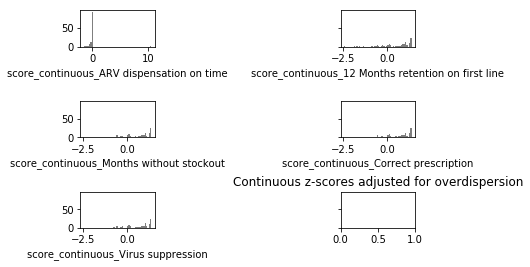

In [174]:
from matplotlib import pyplot as plt

fig,axes = plt.subplots(3,2,sharex=False,sharey=True)

axes[0,0].hist(corrected_scores_continuous[corrected_scores_continuous.columns[0]],bins=50,color='k',alpha=0.5)
axes[0,0].set_xlabel(corrected_scores_continuous.columns[0])

axes[0,1].hist(corrected_scores_continuous[corrected_scores_continuous.columns[1]],bins=50,color='k',alpha=0.5)
axes[0,1].set_xlabel(corrected_scores_continuous.columns[1])

axes[1,0].hist(corrected_scores_continuous[corrected_scores_continuous.columns[1]],bins=50,color='k',alpha=0.5)
axes[1,0].set_xlabel(corrected_scores_continuous.columns[2])

axes[1,1].hist(corrected_scores_continuous[corrected_scores_continuous.columns[1]],bins=50,color='k',alpha=0.5)
axes[1,1].set_xlabel(corrected_scores_continuous.columns[3])

axes[2,0].hist(corrected_scores_continuous[corrected_scores_continuous.columns[1]],bins=50,color='k',alpha=0.5)
axes[2,0].set_xlabel(corrected_scores_continuous.columns[4])

plt.subplots_adjust(wspace=2.5,hspace=1.5)
plt.title("Continuous z-scores adjusted for overdispersion")

Text(0.5, 1.0, 'Normal z-scores adjusted for overdispersion')

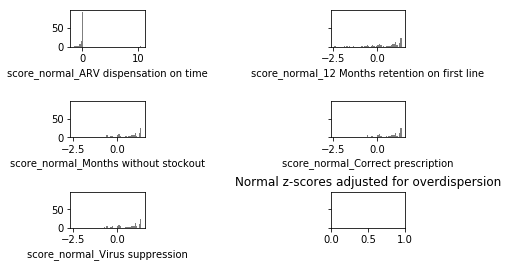

In [175]:
from matplotlib import pyplot as plt

fig,axes = plt.subplots(3,2,sharex=False,sharey=True)

axes[0,0].hist(corrected_scores_norm[corrected_scores_norm.columns[0]],bins=50,color='k',alpha=0.5)
axes[0,0].set_xlabel(corrected_scores_norm.columns[0])

axes[0,1].hist(corrected_scores_norm[corrected_scores_norm.columns[1]],bins=50,color='k',alpha=0.5)
axes[0,1].set_xlabel(corrected_scores_norm.columns[1])

axes[1,0].hist(corrected_scores_norm[corrected_scores_norm.columns[1]],bins=50,color='k',alpha=0.5)
axes[1,0].set_xlabel(corrected_scores_norm.columns[2])

axes[1,1].hist(corrected_scores_norm[corrected_scores_norm.columns[1]],bins=50,color='k',alpha=0.5)
axes[1,1].set_xlabel(corrected_scores_norm.columns[3])

axes[2,0].hist(corrected_scores_norm[corrected_scores_norm.columns[1]],bins=50,color='k',alpha=0.5)
axes[2,0].set_xlabel(corrected_scores_norm.columns[4])

plt.subplots_adjust(wspace=2.5,hspace=1.5)
plt.title("Normal z-scores adjusted for overdispersion")

The **z-scores** obtained with the two different methods are really close. Therefore, in the following we only keep the *continuous z-scores*.

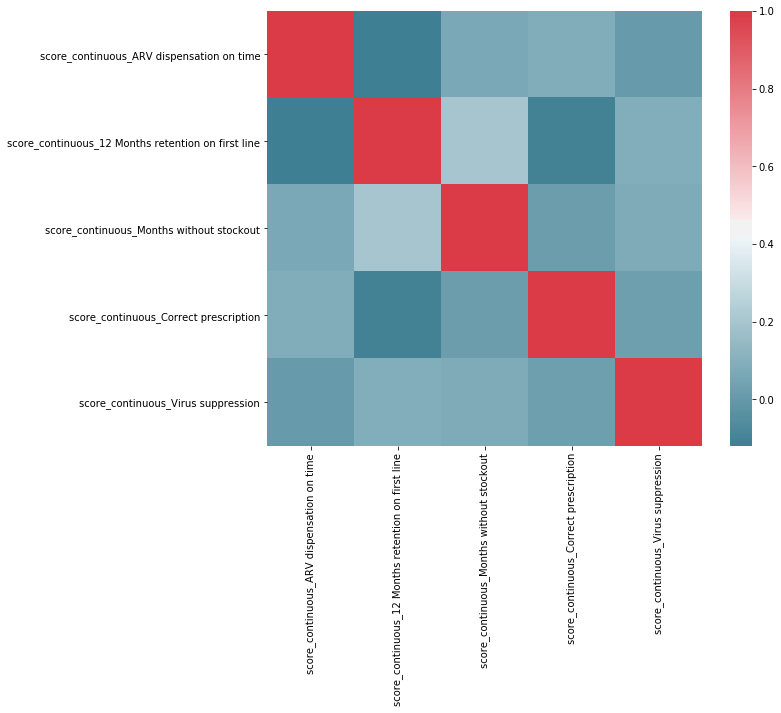

In [178]:
#plt.matshow(corrected_scores_continuous.corr())
#plt.show()
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = corrected_scores_continuous.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Surprisingly (or not), the 5 IAPs are scarcely correlated.

In [228]:
w = []
for i in range(5):
    w.append(1/sum(corr[corr.columns[i]]))

print(w)

[0.9665916360236326, 0.9394173994943406, 0.7355728039268268, 0.97832927749671, 0.8368611774831336]


In [229]:
denom = 0
for i in range(5):
    for j in range(5):
        denom = denom + corr.iloc[i,j]*w[i]*w[j]
        
print(denom)

4.4419213898355485


In [277]:
corrected_scores_continuous = corrected_scores_continuous.reset_index()


ValueError: cannot insert level_0, already exists

In [241]:
corrected_scores_continuous.iloc[0,2:7] 

score_continuous_ARV dispensation on time            -0.673002
score_continuous_12 Months retention on first line    1.339568
score_continuous_Months without stockout             -0.271655
score_continuous_Correct prescription                 0.000000
score_continuous_Virus suppression                   -1.022155
Name: 0, dtype: float64

In [247]:
corrected_scores_continuous.columns[3]

'score_continuous_12 Months retention on first line'

In [254]:
weighted_zscores = pd.DataFrame()
for j in range(2,7):
    weighted_zscores[corrected_scores_continuous.columns[j]] = w[j-2]*corrected_scores_continuous[corrected_scores_continuous.columns[j]]

In [255]:
weighted_zscores.head()

,score_continuous_ARV dispensation on time,score_continuous_12 Months retention on first line,score_continuous_Months without stockout,score_continuous_Correct prescription,score_continuous_Virus suppression
0,-0.650518,1.258413,-0.199822,0.000000,-0.855402
1,-0.308996,1.258413,0.000000,0.000000,-0.855402
2,-0.081315,0.694297,0.000000,0.000000,-0.855402
3,-0.048789,0.954658,-0.424622,-4.036735,-0.855402
4,-0.097578,0.867871,0.000000,0.000000,-0.855402


In [256]:
numerator = []
for i in range(len(weighted_zscores)):
    numerator.append(np.nansum(weighted_zscores.iloc[i,1:6]))


[0.20318930538437652, 0.40301163318239563, -0.16110465894854986, -4.362100487849298, 0.012469584784048693, 0.012469584784048693, -0.8289429942505091, -9.023632975595863, -0.2819721789872929, -4.056616814700935, -0.481794506785312, -0.36875930085359215, -0.10839793525469421, -0.7250103955164807, -0.05717206021452148, -0.10839793525469421, -0.06500437432154471, 0.44640519411554536, -3.1552603633358753, -0.3780724636142981, -0.768614512012645, 0.44640519411554536, 0.44640519411554536, 0.3596180722492459, 0.40301163318239563, -0.6894491486903547, -0.5685816286516112, -2.00056913944555, -0.3346789026811484, 0.021782747544754733, -0.2819721789872929, -1.4629114869430393, -1.2025501213441414, 0.44640519411554536, -0.8120080729457947, -0.5685816286516112, -1.8873233779508154, 0.44640519411554536, 0.44640519411554536, 0.44640519411554536, -1.817681732952245, -2.8758515610895365, -3.4058874550480382, -0.2912853417479988, -0.8816497179443648, -2.311735268958591, -2.311735268958591, 0.403011633182

In [261]:
agg_zscore = numerator/np.sqrt(denom)
len(agg_zscore)

121

We have obtained an aggregated z-score for each fosa.

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  1.,  2.,  0.,  3.,  0.,  1.,  3.,  3.,  3.,  1.,  7.,  4.,
         2., 13.,  7.,  5., 15., 13.,  6., 24.,  0.,  1.,  2.]),
 array([-4.2815004 , -4.18541308, -4.08932576, -3.99323844, -3.89715112,
        -3.8010638 , -3.70497648, -3.60888916, -3.51280184, -3.41671452,
        -3.3206272 , -3.22453988, -3.12845256, -3.03236524, -2.93627792,
        -2.8401906 , -2.74410328, -2.64801596, -2.55192864, -2.45584133,
        -2.35975401, -2.26366669, -2.16757937, -2.07149205, -1.97540473,
        -1.87931741, -1.78323009, -1.68714277, -1.59105545, -1.49496813,
        -1.39888081, -1.30279349, -1.20670617, -1.11061885, -1.01453153,
        -0.91844421, -0.82235689, -0.72626957, -0.63018226, -0.53409494,
        -0.43800762, -0.3419203 , -0.24583298, -0.14974566, -0.05365834,
         0.04242898,  0.1385163 ,  0.23460362,  0.33069094,

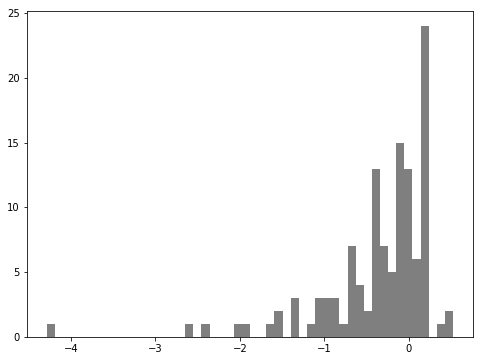

In [259]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.hist(agg_zscore,bins=50,color='k',alpha=0.5)

In [265]:
iap_data_2016_score["Aggregated_zscore"] = pd.Series(agg_zscore, index = iap_data_2016_score.index)

In [275]:
iap_data_2016_score.head()

,province,fosa,annee,ARV dispensation on time,12 Months retention on first line,Months without stockout,Correct prescription,Virus suppression,On time consultation,12 Month LTFU,...,score_normal_12 Months retention on first line,score_continuous_Months without stockout,score_normal_Months without stockout,score_continuous_Correct prescription,score_normal_Correct prescription,score_continuous_Virus suppression,score_normal_Virus suppression,Aggregated_zscore,Z<-1,Z_lessThan_1
2,NORD KIVU,HP GOMA,2016,50.0,99.0,92.0,100.0,0.0,NaN,NaN,...,1.650891,-0.32,-0.308093,0.0,0.000000,-14.084507,-7.439093,0.096409,False,0
5,NORD KIVU,HGR VIRUNGA,2016,71.0,99.0,100.0,100.0,0.0,NaN,NaN,...,1.650891,0.00,0.000000,0.0,0.000000,-14.084507,-7.439093,0.191219,False,0
8,NORD KIVU,CSR KAHEMBE,2016,85.0,86.0,100.0,100.0,0.0,NaN,NaN,...,0.910837,0.00,0.000000,0.0,0.000000,-14.084507,-7.439093,-0.076440,False,0
29,NORD KIVU,HEAL AFRICA,2016,87.0,92.0,83.0,86.0,0.0,NaN,NaN,...,1.252400,-0.68,-0.654697,-28.0,-4.172464,-14.084507,-7.439093,-2.069713,True,1
32,NORD KIVU,CS MURARA,2016,84.0,90.0,100.0,100.0,0.0,NaN,NaN,...,1.138546,0.00,0.000000,0.0,0.000000,-14.084507,-7.439093,0.005917,False,0


In [272]:
iap_data_2016_score["Z_lessThan_1"] = pd.to_numeric(iap_data_2016_score.Aggregated_zscore < -1, errors = "coerce")

In [274]:
iap_data_2016_score["Z_lessThan_1"] = iap_data_2016_score.Z_lessThan_1.astype(int)

In [276]:
iap_data_2016_score.Z_lessThan_1.sum()

16

We dichotomize the aggregated z-scores into whether or not $Z < -1$.
We are now switching back to the routinely collected data to see how a classification model would perform in terms of predicting this binary outcome.

In [347]:
useful_variables = full_data[~(full_data.population == "vih_positive") &  
                             ~(full_data.action.str.contains("tb|cv|_ist|dead|cotrim|nut|treatment_supplement|no_treatment_response|counciled_tested")) &
                             ~(full_data.sub_population.str.contains("soutien"))]

In [348]:
len(useful_variables)

704

In [349]:
treat_scheme = ["azt_3tc_lpv_r","tdf_ftc_nvp","abc_3tc_nvp","abc_3tc_efv","azt_3tc_efv","tdf_3tc_efv",
                "tdf_3tc_nvp","tdf_3tc_lpv_r","tdf_ftc_efv","azt_3tc_nvp","abc_3tc_lpv_r","tdf_ftc_lpv_r"]

treatments = useful_variables[useful_variables.sub_population.isin(treat_scheme)]
treatments_fu = treatments.groupby(["province","fosa","monthly","sub_population"]).value.sum().reset_index()
treatments_fu["line"] = 'first_line'
treatments_fu.loc[treatments_fu.sub_population.str.contains("lpv"),"line"] = "second_line"
line_fu = treatments_fu.groupby(["province","fosa","line"]).value.mean().reset_index()
line_fu = line_fu.set_index(["province","fosa"]).pivot(columns = "line")["value"].reset_index()

In [350]:
len(line_fu)

4

In [351]:
pdv_data = useful_variables[(useful_variables.action == "pdv")]
pdv_data.value = pd.to_numeric(pdv_data.value)
pdv_data = pdv_data.groupby(["province","fosa"]).value.mean().reset_index()
pdv_data.columns = ["province", "fosa", "n_pdv"]

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [352]:
print(pdv_data)

    province         fosa     n_pdv
0  nord kivu     hgr beni  2.666667
1  nord kivu  hgr oicha    3.750000


In [353]:
pvvih_data = useful_variables[(useful_variables.population == "pvvih") & (useful_variables.action == "enrolled_hiv_services")]
pvvih_data.value = pd.to_numeric(pvvih_data.value)
pvvih_data = pvvih_data.groupby(["province","fosa"]).value.mean().reset_index()
pvvih_data.columns = ["province", "fosa", "n_pvvih"]

In [354]:
len(pvvih_data)

2

In [355]:
stock_out_data = useful_variables[useful_variables.action == "rupture_stock_mois"]
def stock_out_prob(data):    
    return sum(data == "true") / len(data)


stock_out_data = stock_out_data.groupby(["province","fosa"]).value.apply(stock_out_prob).reset_index()
stock_out_data.columns = ["province", "fosa", "stockout_perc"]

In [356]:
len(stock_out_data)

4

In [357]:
cmm_data = useful_variables[useful_variables.action == "cmm_mois"]

cmm_data = cmm_data.groupby(["province","fosa","monthly"]).value.sum().reset_index().groupby(["province","fosa"]).value.sum().reset_index()
cmm_data.columns = ["province", "fosa", "cmm"]

In [358]:
len(cmm_data)

4

In [284]:
covariables = cmm_data.merge(stock_out_data).merge(line_fu).merge(pdv_data)#.merge(pvvih_data)#.merge(pdv_data)#.merge(line_fu
print(len(covariables))

2


I'm really surprised that I end up with so few rows for the *useful covariates*
@Grégoire, do you see anything different from what you did in your notebook?